# 3.three dims models reconstruction of subpopulations

This notebook demonstrates the process of the 3D models reconstruction of subpopulations based on 3D spatial transcriptome data. This is done in the following three steps.

1. Construct the 3D point cloud model;
2. Construct the mesh model based on the 3D point cloud model;
3. Save the models.

This example reconstructs 3D Drosophila CNS model based on 3D spatial transcriptome data of Drosophila CNS.

## Packages

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.colors as mplc

sys.path.insert(0, "/home/yao/PythonProject/Test_packages/dynamo-release")
sys.path.insert(0, "/home/yao/PythonProject/Yao_packages/spateo-release")
import dynamo as dyn
import spateo as st

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: Future

## Data source

In [3]:
# embryo anndata
adata = st.read_h5ad("E7-9h_cellbin_tdr_v2.h5ad")
adata

AnnData object with n_obs × n_vars = 25857 × 8136
    obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
    uns: 'PCs', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'explained_variance_ratio_', 'latter_models_align', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'spatial'
    obsm: '3d_align_spatial', 'align_spatial', 'bbox', 'before_3d_align_spatial', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial'
    layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced'

In [4]:
# embryo pc&mesh
embryo_pc = st.tdr.read_model(filename="E7-9h_embryo_aligned_pc_model.vtk")
embryo_mesh = st.tdr.read_model(filename="E7-9h_embryo_aligned_mesh_model.vtk")
embryo_pc.point_data, embryo_mesh.cell_data

(pyvista DataSetAttributes
 Association     : POINT
 Active Scalars  : cell_size
 Active Vectors  : None
 Active Texture  : None
 Active Normals  : None
 Contains arrays :
     cell_size               float64    (25857,)             SCALARS
     tissue_rgba             float32    (25857, 4)
     tissue                  <U14       (25857,)
     obs_index               <U16       (25857,)
     cell_radius             float64    (25857,),
 pyvista DataSetAttributes
 Association     : CELL
 Active Scalars  : tissue_rgba
 Active Vectors  : None
 Active Texture  : None
 Active Normals  : None
 Contains arrays :
     tissue_rgba             float32    (39992, 4)           SCALARS
     vtkOriginalCellIds      int64      (39992,)
     tissue                  <U12       (39992,))

## Customize cpo through an interactive window

In [5]:
cpo, _ = st.pl.three_d_plot(
    model=st.tdr.collect_models([embryo_pc, embryo_mesh]),
    key="tissue",
    model_style=["points", "surface"],
    jupyter=False,
    window_size=(512, 512),
)
cpo

[(553.2878243418567, 1098.4674808068507, 277.4399476053088),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.16299443079060863, -0.16480753930466982, 0.9727647662819544)]

## Extraction of subpopulation from embryon model

In [6]:
subpopulation = "CNS"
subpopulation_rpc = st.tdr.three_d_pick(model=embryo_pc, key="tissue", picked_groups=subpopulation)[0]
subpopulation_tpc = st.tdr.interactive_rectangle_clip(model=subpopulation_rpc, key="tissue", invert=True, bg_model=embryo_pc)[0]

  File "/home/yao/PythonProject/Yao_packages/spateo-release/spateo/tdr/widgets/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'
  File "/home/yao/PythonProject/Yao_packages/spateo-release/spateo/tdr/widgets/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'
  File "/home/yao/PythonProject/Yao_packages/spateo-release/spateo/tdr/widgets/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'


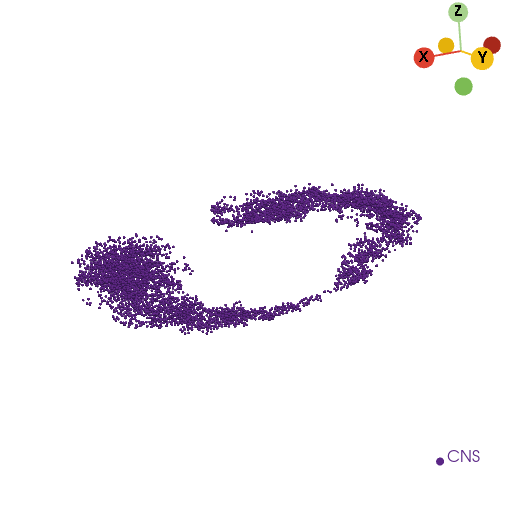

In [7]:
st.pl.three_d_plot(
    model=subpopulation_tpc,
    key="tissue",
    model_style="points",
    model_size=3,
    opacity=[1, 0.6, 1],
    jupyter="static",
    cpo=cpo,
    window_size=(512, 512),
)

## 3D reconstruction of subpopulation mesh model

In [19]:
subpopulation_color = mplc.to_hex(c=subpopulation_tpc["tissue_rgba"][0], keep_alpha=True)
subpopulation_mesh, subpopulation_pc = st.tdr.construct_surface(
    pc=subpopulation_tpc,
    key_added="tissue",
    label=subpopulation,
    color=subpopulation_color,
    alpha=1.0,
    cs_method="marching_cube",
    cs_args={"mc_scale_factor": 1.},
    smooth=3000,
    scale_factor=1
)
subpopulation_mesh.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : tissue_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    vtkOriginalCellIds      int64      (39992,)
    tissue_rgba             float32    (39992, 4)           SCALARS
    tissue                  <U3        (39992,)

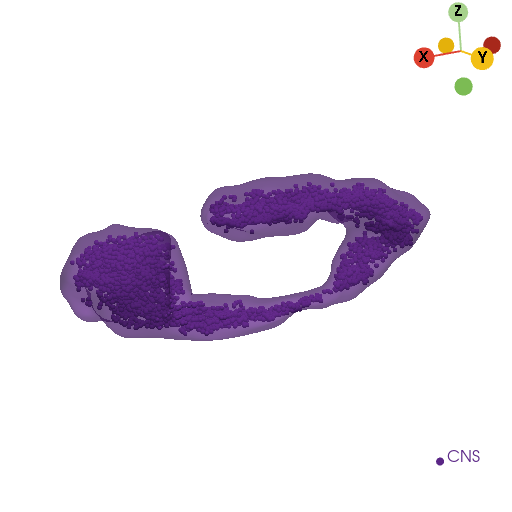

In [20]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([subpopulation_pc, subpopulation_mesh]),
    key="tissue",
    model_style=["points", "surface"],
    model_size=5,
    opacity=[1, 0.5],
    jupyter="static",
    cpo=cpo,
)

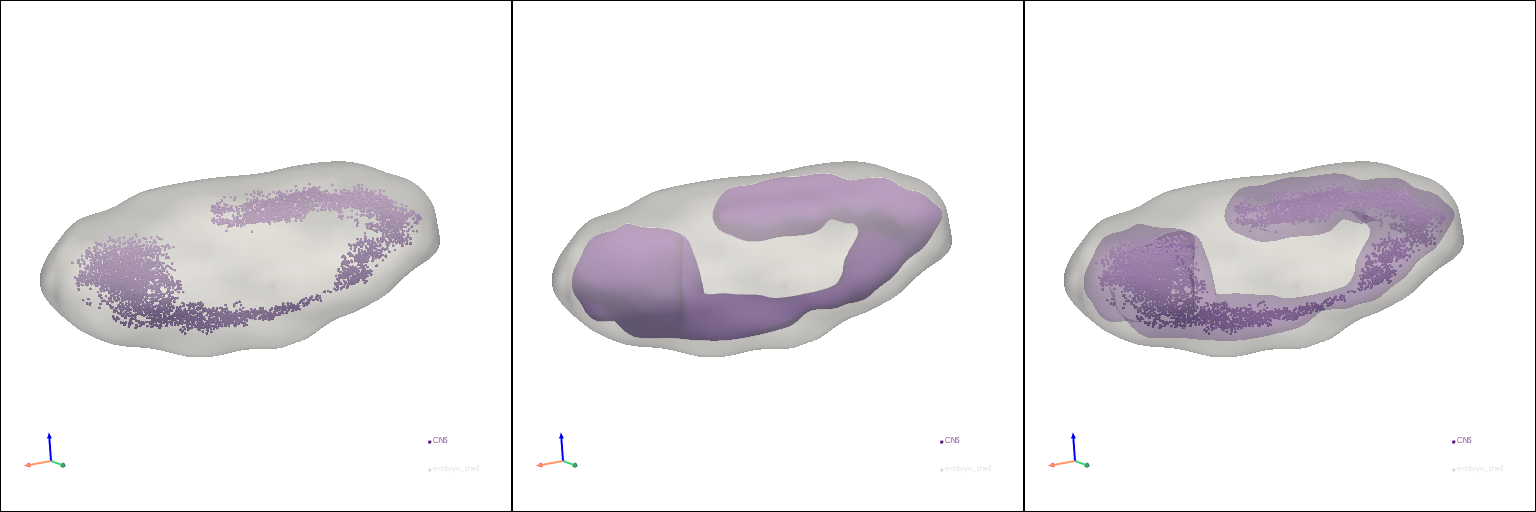

In [21]:
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(
        [
            st.tdr.collect_models([embryo_mesh, subpopulation_pc]),
            st.tdr.collect_models([embryo_mesh, subpopulation_mesh]),
            st.tdr.collect_models([embryo_mesh, subpopulation_pc, subpopulation_mesh])
        ]
    ),
    key="tissue",
    model_style=[["surface", "points"], "surface", ["surface", "points", "surface"]],
    model_size=3,
    opacity=[1, 1, [1, 1, 0.3]],
    shape=(1, 3),
    window_size=(512*3, 512),
    jupyter="static",
    cpo=cpo,
)

## Save models

In [ ]:
st.tdr.save_model(model=subpopulation_pc, filename="subpopulatio_pc_model.vtk")
st.tdr.save_model(model=subpopulation_mesh, filename="subpopulatio_mesh_model.vtk")